In [1]:
s3_data ="s3://aegovan-data/processed_dataset/test_unique_pub_v6_max_neg.json"
data_dir = "temp"

s3_model_single_path = "s3://aegovan-data/results/ppi-bert-extractor-neg-2019-11-02-08-08-28-562/output/output.tar.gz"
s3_model_path_format = "s3://aegovan-data/results/{}/output/output.tar.gz"

In [2]:
!pip install scikit-plot==0.3.7


You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp  $s3_model_single_path $data_dir

download: s3://aegovan-data/results/ppi-bert-extractor-neg-2019-11-02-08-08-28-562/output/output.tar.gz to temp/output.tar.gz


In [4]:
!tar -xf $data_dir/output.tar.gz -C $data_dir


In [5]:
!rm $data_dir/output.tar.gz


In [6]:
!ls -l $data_dir

total 5192
-rw-r--r--  1 aeg  1896053708  2648516 Nov  2 21:09 predicted.json
-rw-r--r--  1 aeg  1896053708     3059 Nov  2 21:09 training_scores_epoch_Objectdump_20191102_100917_1e53e8ef-0eac-4f94-9db0-510a146f5a58.json
-rw-r--r--  1 aeg  1896053708     3065 Nov  2 21:09 validation_scores_epoch_Objectdump_20191102_100917_250f9b10-8cba-4aeb-a1bb-b621bb90ec24.json


In [7]:
import tarfile
import pandas as pd
import json
from pandas.io.json import json_normalize
import tempfile 
import os
import boto3
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
import scikitplot as skplt

In [8]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [9]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [10]:
import glob, os

single_test_results_file = os.path.join(data_dir, "predicted.json")
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [11]:
#download_single_file(s3_data, test_input_file)

In [12]:
import pandas as pd

In [13]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [14]:
df_single_test_results = pd.read_json(single_test_results_file)
df_single_test_results["actual"] = df_single_test_results["class"]

In [15]:
df_single_test_results.columns


Index(['pubmedabstract', 'normalised_abstract', 'participant1Id',
       'participant2Id', 'class', 'predicted', 'confidence_scores', 'actual'],
      dtype='object')

In [16]:
df_single_test_results.shape

(894, 8)

In [17]:
df_single_test_results.head(n=2)

,pubmedabstract,normalised_abstract,participant1Id,participant2Id,class,predicted,confidence_scores,actual
0,"MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for MEKK3-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. MEKK3-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and p38 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of MEKK3, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and MEK, suggesting that a negative charge at Ser526 was necessary for MEKK3 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of MEKK3 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of MEKK3 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous MEKK3 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for MKK6 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between MEKK3 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of MEKK3 is an autophosphorylation site within the T-loop that is regulated by PP2A and 14-3-3 proteins.","Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of Q99759 is an autophosphorylation site within the T-loop that is regulated by Q15257 and 14-3-3 proteins.",Q15257,P52564,other,other,"{'acetylation': -1.6813824177, 'demethylation': -3.5925014019, 'dephosphorylation': -0.45023748280000003, 'deubiquitination': -3.1012539864, 'methylation': -2.1921753883, 'other': 3.9562005997, 'phosphorylation': 3.4436149597, 'ubiquitination': -1.9302625656

## Analyse Results

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [19]:
df_single_test_results.shape

(894, 8)

In [20]:
def get_predicted_confidence(df):
    import math
    keys = list(df["confidence_scores"][0].keys())
    # This is log softmax, convert to softmax prob
    for k in keys:
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))

    df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )
    
    return df

def get_f_scores(df):
    from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

    scores = {}
    scores["F1_macro"] = f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["precision_macro"]  = precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["recall_macro"] = recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
    scores["F1_micro"]  = f1_score(df["actual"], df["predicted"], average='micro' ,sample_weight=None)  





    scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
    
    
    return scores

def plot_confusion_matrix(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt


    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(5,5),  x_tick_rotation=90)
    plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

    skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(4,4), normalize=False, x_tick_rotation=90 )
    plt.savefig("confusionmatrix_unnormalised.png", bbox_inches='tight')





In [21]:
df_single_test_results = get_predicted_confidence(df_single_test_results)

In [22]:

get_f_scores(df_single_test_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'F1_macro': 0.4795701323923318,
 'precision_macro': 0.52250770868919,
 'recall_macro': 0.48575990385583406,
 'F1_micro': 0.8557046979865772,
 'accuracy': 0.8557046979865772}

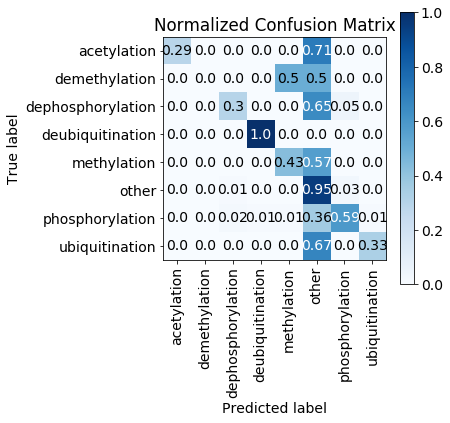

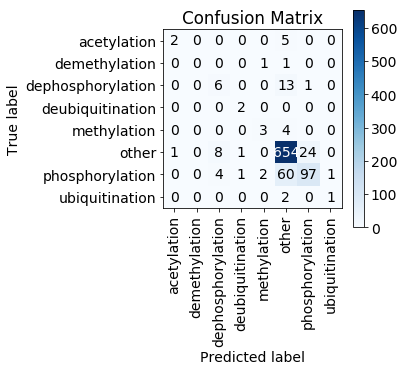

In [23]:
plot_confusion_matrix(df_single_test_results)

In [24]:
def plot_pr_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())
    
    skplt.metrics.plot_precision_recall(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))



In [25]:
def plot_roc_curve(df):
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    keys = list(df["confidence_scores"][0].keys())


    skplt.metrics.plot_roc(df_single_test_results["actual"], df_single_test_results[keys], figsize=(5,5)).legend(bbox_to_anchor=(1,1))





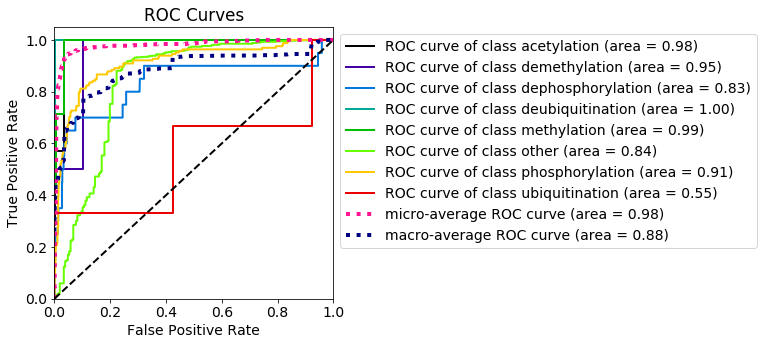

In [26]:
plot_roc_curve(df_single_test_results)

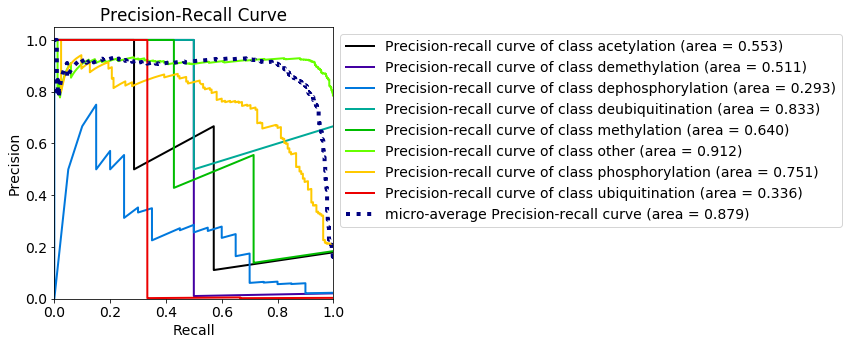

In [27]:
plot_pr_curve(df_single_test_results)


## Training / Validation epoch fit

In [28]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [29]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
38,38,3.688703,98.889905
39,39,3.384684,98.826363
41,41,3.431755,98.821055
42,42,3.485756,98.761226
40,40,3.587734,98.761024
36,36,4.394363,98.748271
35,35,4.708974,98.748271
37,37,4.299220,98.696567
32,32,5.943145,98.678272
34,34,4.708471,98.663077


In [30]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
21,21,40.955091,56.585145
42,42,49.011612,56.058652
38,38,50.519260,55.661394
11,11,32.899003,54.753232
18,18,36.309373,53.577333
10,10,30.911157,52.665641
20,20,39.381706,52.480619
27,27,46.331764,52.012472
30,30,48.516334,51.888049
23,23,44.485245,50.584559


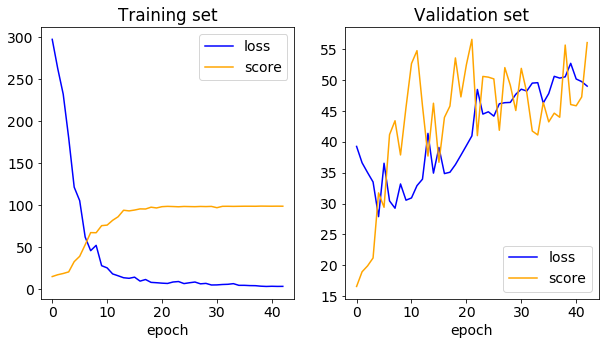

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

## Variation Bert - Objective F-score

In [32]:
import boto3
import re

def search_log(stream_names, filter_pattern, regex_pattern):
    client = boto3.client('logs')

    log_group_name= "/aws/sagemaker/TrainingJobs"

    response = client.filter_log_events(
        logGroupName=log_group_name,
        logStreamNames=stream_names,
        filterPattern= filter_pattern,
        limit=10,
        interleaved=False
    )
    assert len(response["events"]) == 1
    log_message = response["events"][0]["message"]
    
    # extract the cm from string
    prog = re.compile(regex_pattern)
    result = prog.match(log_message)
    
    return result



def get_prf(stream_names, filterPattern):
    regex_pattern = ".*precision, recall, fscore, support\s+\((0\.\d+,\s+0\.\d+,\s+0\.\d+).*"
    
    result = search_log(stream_names, filterPattern, regex_pattern).group(1)

    # normalise string to remove extra space
    result = re.sub("\s+", "", result) 
    
    # split the string, sep by comma..514 62 41 75
    precision, recall, fscore = result.split(",")
    
    return float(precision), float(recall), float(fscore)


    
def get_val_macro_score(stream_names):
    filterPattern =  '"__main__ - INFO - macro average scores"'
    return get_prf(stream_names, filterPattern)

def get_val_micro_score(stream_names):
    filterPattern =  '"__main__ - INFO - micro average scores"'
    return get_prf(stream_names, filterPattern)

def get_log_name(sagemaker_job_name):
    client = boto3.client('logs')
    log_group_name= "/aws/sagemaker/TrainingJobs"
    
    response = client.describe_log_streams(
    logGroupName=log_group_name,
    logStreamNamePrefix=sagemaker_job_name,
    orderBy='LogStreamName',
    descending=False,
    limit=5
)
    assert len(response["logStreams"]) == 1
    
    return  response["logStreams"][0]["logStreamName"]

In [33]:
#precision, recall, fscore
jobs = [
    "ppi-bert-2019-11-24-17-25-37-406",
    "ppi-bert-2019-11-24-17-23-34-503",
    "ppi-bert-2019-11-24-17-22-16-517",
    "ppi-bert-2019-11-24-17-18-42-192",
    "ppi-bert-2019-11-24-17-16-59-176",
    "ppi-bert-2019-11-24-17-15-51-079",
    "ppi-bert-2019-11-24-17-14-21-187",
    "ppi-bert-2019-11-24-17-12-37-190",
    "ppi-bert-2019-11-24-17-11-07-931",
    "ppi-bert-2019-11-24-17-09-56-491"
]

In [34]:
import pandas as pd

val_scores = []
for j in jobs:
    l = get_log_name(j)
    precision, recall, fmacro = get_val_macro_score([l])
    fmicro = get_val_micro_score([l])[2]
    val_scores.append({"jobname": j, "precision":precision*100, "recall": recall*100, "f1-macro": fmacro*100,"f1-micro": fmicro*100})

df_val_variation_scores = pd.DataFrame(val_scores)

In [35]:
df_val_variation_scores .describe()

,f1-macro,f1-micro,precision,recall
count,10.000000,10.000000,10.000000,10.000000
mean,47.149018,79.833729,48.595290,48.709290
std,6.549897,1.793135,6.204623,8.925645
min,40.251261,76.484561,42.116693,38.289313
25%,42.319277,79.038005,43.256393,40.601083
50%,44.990032,80.522565,46.610243,48.063364
75%,52.951462,80.700713,53.587205,53.278262
max,57.306156,82.422803,58.625387,62.759147


In [36]:
best_val_job = df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]["jobname"]

In [37]:
df_val_variation_scores.head(n=10)

,f1-macro,f1-micro,jobname,precision,recall
0,40.709337,76.484561,ppi-bert-2019-11-24-17-25-37-406,43.100216,39.283888
1,44.937687,80.522565,ppi-bert-2019-11-24-17-23-34-503,42.951878,49.202696
2,57.306156,81.235154,ppi-bert-2019-11-24-17-22-16-517,56.707197,62.056368
3,56.103665,77.434679,ppi-bert-2019-11-24-17-18-42-192,54.421349,62.759147
4,45.042377,80.760095,ppi-bert-2019-11-24-17-16-59-176,43.724923,50.641131
5,41.802884,80.522565,ppi-bert-2019-11-24-17-15-51-079,48.078627,38.289313
6,40.251261,79.572447,ppi-bert-2019-11-24-17-14-21-187,42.116693,39.226350
7,55.168745,80.522565,ppi-bert-2019-11-24-17-12-37-190,58.625387,54.157305
8,46.299615,78.859857,ppi-bert-2019-11-24-17-11-07-931,51.084773,46.924032
9,43.868458,82.422803,ppi-bert-2019-11-24-17-09-56-491,45.141859,44.552670


In [38]:
df_val_variation_scores.iloc[df_val_variation_scores["f1-macro"].idxmax()]

f1-macro                              57.3062
f1-micro                              81.2352
jobname      ppi-bert-2019-11-24-17-22-16-517
precision                             56.7072
recall                                62.0564
Name: 2, dtype: object

In [39]:

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


def load_scores_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    
def get_predictions(s3_path):
    tmp_dir = tempfile.mkdtemp()
    outfile = os.path.join(tmp_dir, "output.tar.gz" )
    download_single_file(s3_path, outfile)
    tf = tarfile.open(outfile)
    tf.extractall(path=tmp_dir)
    test_input_file = os.path.join(tmp_dir, "predicted.json")


    df_results =  pd.read_json(test_input_file)
    df_results["actual"] = df_results["class"]
    
    validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(tmp_dir))[0]
    train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(tmp_dir))[0]

    df_val_fit = load_scores_as_df(validation_fit_file)
    df_train_fit = load_scores_as_df(train_fit_file)



    return df_results, df_val_fit, df_train_fit

def get_all_scores (list_of_s3_path):
    scores = []

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        score = {}
        score["key"]=s3_path
        score["F1-score"] = 100*f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Precision"]  =100* precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
        score["Recall"] = 100*recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None) 
        score["Accuracy"] = 100*accuracy_score(df["actual"], df["predicted"])  


        scores.append(score)
        
    return pd.DataFrame(scores)


def get_ensemble (list_of_s3_path):
    scores = {}

    for s3_path in list_of_s3_path:
        df,_,_ = get_predictions(s3_path) 
        scores[s3_path] = df
        
    return scores

In [40]:
%%time

s3_model_paths = []
for k in jobs:
    s3_path = s3_model_path_format.format(k)
    s3_model_paths.append(s3_path)

df_test_variation_scores =  get_all_scores(s3_model_paths)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

CPU times: user 830 ms, sys: 165 ms, total: 995 ms
Wall time: 28.8 s


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
df_test_variation_scores.describe()

,Accuracy,F1-score,Precision,Recall
count,10.000000,10.000000,10.000000,10.000000
mean,83.624161,44.415640,46.029069,46.473381
std,1.378257,5.466596,6.215673,6.944404
min,81.655481,35.378036,34.360841,36.672377
25%,82.718121,41.206243,42.464026,41.690286
50%,83.501119,44.020982,46.181632,46.036507
75%,85.011186,48.580637,51.166508,51.284402
max,85.346756,52.277153,53.896706,58.910655


In [42]:
df_test_variation_scores.query("key == '{}'".format(s3_model_path_format.format(best_val_job)))

,Accuracy,F1-score,Precision,Recall,key
2,85.346756,35.378036,34.360841,38.328614,s3://aegovan-data/results/ppi-bert-2019-11-24-17-22-16-517/output/output.tar.gz


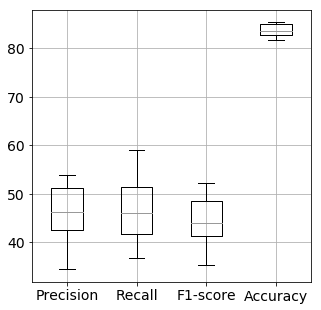

In [43]:

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.style.use('grayscale')

df_test_variation_scores[["Precision", "Recall", "F1-score", "Accuracy"]].boxplot(ax=ax )
#ax.set_title( "BERT Variation - PPI typed dataset" )

plt.savefig("score_variation_typed.eps", bbox_inches='tight')





### Ensemble results

In [44]:
%%time

s3_model_paths = []
for k in jobs:
    job_name = k 
    s3_path = s3_model_path_format.format(job_name)
    s3_model_paths.append(s3_path)

ensemble_results =  get_ensemble(s3_model_paths)

CPU times: user 772 ms, sys: 195 ms, total: 967 ms
Wall time: 46.6 s


In [45]:
import math
def populate_predicted_confidence(df):
    keys = list(df["confidence_scores"][0].keys())
    # This is log softmax, convert to softmax prob
    for k in keys:
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
        df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))

    df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )

In [46]:
vote_base="votes_{}"
def populate_ensemble_predicted_confidence(ensemble_results_dict):
    ensemble_results = list(ensemble_results_dict.values())
    base_df= ensemble_results[0]
    keys = list(base_df["confidence_scores"][0].keys())
    vote_keys = [ vote_base.format(k) for k in keys]
    result = base_df[["actual", "normalised_abstract", "participant1Id", "participant2Id"]  ]
    result["index"] = base_df.index
    for v in vote_keys + keys:
        result[v] = 0.0
    # This is log softmax, convert to softmax prob
    for df in ensemble_results:
        for k in keys:
            populate_predicted_confidence(df)
        
            result[k] += df[k]
            result[vote_base.format(k)] += df.apply(lambda r: 1 if r["predicted"] == k else 0 , axis=1)


            
    
    # populate voting
    result["ensemble_predicted_confidence"] =  result.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )
    result["ensemble_predicted"] =  result.apply(lambda r: keys[list(r[ keys]).index(max(r[ keys]))], axis=1  )


    result["ensemble_majority_prediction"] = result.apply(lambda r: keys[list(r[ vote_keys]).index(max(r[ vote_keys]))], axis=1 )
    result["ensemble_confidence_majority_prediction"] = result.apply(lambda r: r[r["ensemble_majority_prediction"]], axis=1 )
    
    return result




In [47]:
def get_best_result(df_dict, best_val_key):
    for k in df_dict:
        if best_val_key in k:
            return k,  df_dict[k]
      

In [48]:
k, best_df = get_best_result(ensemble_results, best_val_job)



In [49]:
best_df.head()

,pubmedabstract,normalised_abstract,participant1Id,participant2Id,class,predicted,confidence_scores,actual
0,"MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for MEKK3-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. MEKK3-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and p38 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of MEKK3, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and MEK, suggesting that a negative charge at Ser526 was necessary for MEKK3 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of MEKK3 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of MEKK3 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous MEKK3 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for MKK6 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between MEKK3 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of MEKK3 is an autophosphorylation site within the T-loop that is regulated by PP2A and 14-3-3 proteins.","Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of Q99759 is an autophosphorylation site within the T-loop that is regulated by Q15257 and 14-3-3 proteins.",Q15257,P52564,other,other,"{'acetylation': -1.8280018568, 'demethylation': -1.9923496246, 'dephosphorylation': -0.8720393777000001, 'deubiquitination': -1.0949733257, 'methylation': -1.4718147516, 'other': 5.6033182144, 'phosphorylation': 0.0815887451, 'ubiquitination': -1.61197292800

In [50]:

df_ensemble = populate_ensemble_predicted_confidence(ensemble_results)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [51]:
df_ensemble.head(n=3)

,actual,normalised_abstract,participant1Id,participant2Id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction
0,other,"Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of Q99759 is an autophosphorylation site within the T-loop that is regulated by Q15257 and 14-3-3 proteins.",Q15257,P52564,0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,3.113588,1.421410,13.044765,2.022279,2.234575,2691.359356,12.067992,2.587008,0.986623,other,other,2691.359356
1,other,"Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the 

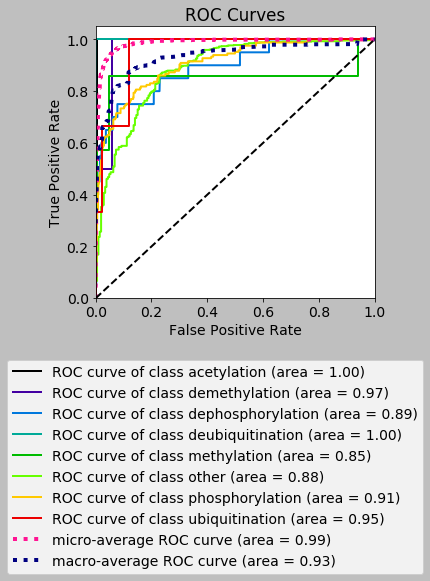

In [52]:

import matplotlib.pyplot as plt
import scikitplot as skplt
keys = list(best_df["confidence_scores"][0].keys())


skplt.metrics.plot_roc(df_ensemble["actual"], df_ensemble[keys], figsize=(5,5)).legend(bbox_to_anchor=(1.2,-0.2))


plt.savefig("plot_roc_ensemble.eps", bbox_inches='tight')


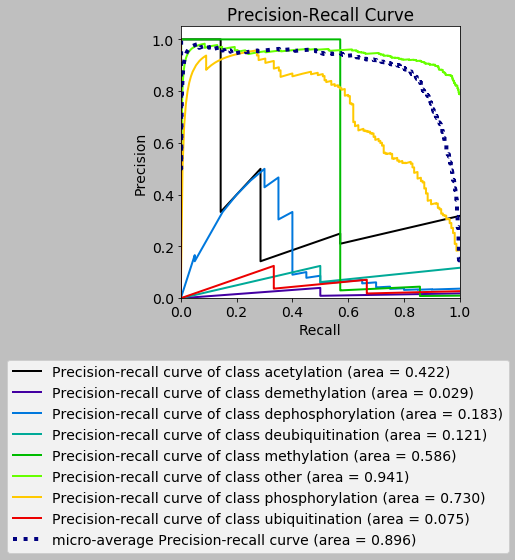

In [53]:

import matplotlib.pyplot as plt
import scikitplot as skplt
keys = list(best_df["confidence_scores"][0].keys())



skplt.metrics.plot_precision_recall(best_df["actual"], best_df[keys], figsize=(5,5)).legend(bbox_to_anchor=(1.2,-0.2))


plt.savefig("plot_pr_bestval_on_test.eps", bbox_inches='tight')



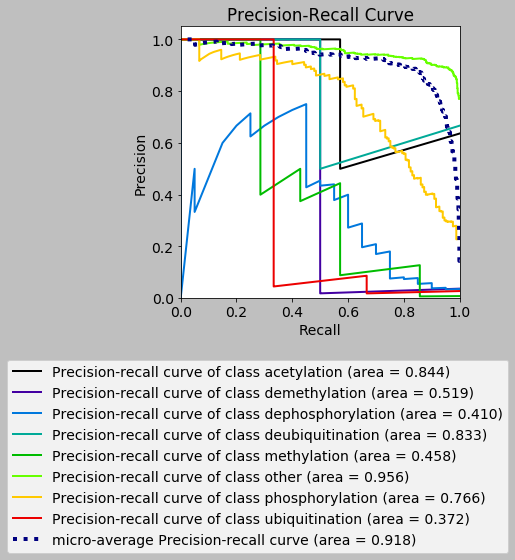

In [54]:

import matplotlib.pyplot as plt
import scikitplot as skplt
keys = list(best_df["confidence_scores"][0].keys())



skplt.metrics.plot_precision_recall(df_ensemble["actual"], df_ensemble[keys], figsize=(5,5)).legend(bbox_to_anchor=(1.2,-0.2))


plt.savefig("plot_pr_ensemble.eps", bbox_inches='tight')



### Get thresholds to use

In [55]:
import sklearn
from sklearn.preprocessing import label_binarize
import numpy as np 

def get_thrsholds(df, field_actual, classes, confidence_colms):
    result = []
    actual_binarized = label_binarize(df[field_actual], classes=classes)
    predicted_binarized = np.true_divide(df[confidence_colms].values, df[confidence_colms].values.sum(axis=1, keepdims=True)) 
    #predicted_binarized[predicted_binarized < 0.5] = 0.0
    for i in range(actual_binarized.shape[1]):
        
        _, _, thres = sklearn.metrics.precision_recall_curve(actual_binarized[:,i],predicted_binarized[:,i])
  
        best_pr = -1
        pr = []
        rc = []
        for ti, t in enumerate(thres):
            p_full = predicted_binarized[:,i]
            a_full = actual_binarized[:,i]
            #a = a_full[p_full >= t]
            p_label = ( (p_full >= t) & (t > 0.5)).astype(int)
            
#             cut_off = 0.5 if t < 0.5 else t
#             p_label = (p>0.5).astype(int)

            pr.append( sklearn.metrics.precision_score(a_full,p_label, average='binary' ,sample_weight=None))
            rc.append(sklearn.metrics.recall_score(a_full,p_label))
            
            if best_pr < pr[-1]:
                idx =  ti
            if best_pr == 1.0:
                break
            

#         print(keys[i])
#         print(np.round(pr,4))
#         print(np.round(thres,4))



        #get first / lowest index of highest precision
        #last element then it is always one.. so not applicable
        # idx = np.argmax(pr[:-1])
       
        result.append( {
            "key" : keys[i],
            "threshold" :  thres[idx-1],
            "precision" : pr[idx],
            "recall" : rc[idx]
        })
    return result




In [56]:
df_ensemble_best_threshold = pd.DataFrame(get_thrsholds(df_ensemble, field_actual = "actual", classes =keys,confidence_colms=keys ))
df_ensemble_best_threshold

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,key,precision,recall,threshold
0,acetylation,1.0,0.142857,0.834833
1,demethylation,0.0,0.000000,0.081247
2,dephosphorylation,0.0,0.000000,0.540856
3,deubiquitination,1.0,0.500000,0.324735
4,methylation,1.0,0.285714,0.819191
5,other,1.0,0.001453,0.998295
6,phosphorylation,1.0,0.012121,0.989904
7,ubiquitination,0.0,0.000000,0.162570


In [57]:
df_ensemble.query("actual == 'deubiquitination' or ensemble_predicted == 'deubiquitination'")[[ "actual", "ensemble_predicted", "ensemble_predicted_confidence"]].sort_values(by = ["ensemble_predicted_confidence"])

,actual,ensemble_predicted,ensemble_predicted_confidence
648,other,deubiquitination,0.309593
776,deubiquitination,deubiquitination,0.324735
727,deubiquitination,deubiquitination,0.558567


### Get Scores

In [58]:
df_ensemble.shape

(894, 25)

In [59]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_predicted"],sample_weight=None)
print(scores)



{'F1_macro': 0.5399596900683856, 'precision_macro': 0.6636742637563926, 'recall_macro': 0.5139799154334038, 'F1_micro': 0.8668903803131991, 'accuracy': 0.8668903803131991}


/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


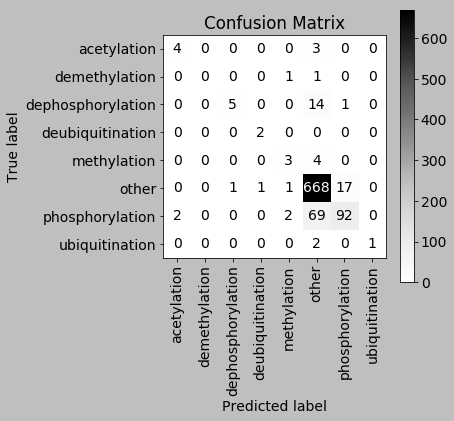

In [60]:
import matplotlib.pyplot as plt
import scikitplot as skplt

fig,ax = plt.subplots(1, 1, figsize=(5,5))


# skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], normalize=True , ax=ax[0],  x_tick_rotation=90)
# plt.savefig("confusionmatrix_normalised.png", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], ax=ax, normalize=False, x_tick_rotation=90, cmap="Greys" )
plt.savefig("confusionmatrix_unnormalised.eps", bbox_inches='tight')



In [61]:
from sklearn.metrics import confusion_matrix
labels = df_ensemble["actual"].unique()
confusion_df = pd.DataFrame(data= confusion_matrix(df_ensemble["actual"], df_ensemble["ensemble_predicted"], labels=labels), index=labels, columns=labels)

confusion_df.to_csv("confusion.matrix.csv")
confusion_df

,other,phosphorylation,dephosphorylation,methylation,acetylation,deubiquitination,ubiquitination,demethylation
other,668,17,1,1,0,1,0,0
phosphorylation,69,92,0,2,2,0,0,0
dephosphorylation,14,1,5,0,0,0,0,0
methylation,4,0,0,3,0,0,0,0
acetylation,3,0,0,0,4,0,0,0
deubiquitination,0,0,0,0,0,2,0,0
ubiquitination,2,0,0,0,0,0,1,0
demethylation,1,0,0,1,0,0,0,0


In [62]:
df_ensemble["particpant1Exists"] = df_ensemble.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpant2Exists"] = df_ensemble.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
df_ensemble["particpantsExists"] = df_ensemble.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)




In [63]:
df_ensemble.query("actual != ensemble_predicted  and  particpantsExists"  )[["ensemble_predicted", "actual","normalised_abstract", "participant1Id", "participant2Id"]].sample(n=10)

,ensemble_predicted,actual,normalised_abstract,participant1Id,participant2Id
845,other,phosphorylation,"Sustained activation of P09874 (P09874) and 5594;5595 (5595;5594) both promote neuronal death. Here we identify a direct link between these two cell death pathways. In a rat model of hypoglycemic brain injury, neuronal P09874 activation and subsequent neuronal death were blocked by the 5595;5594 inhibitor 2-(2-amino-3-methoxyphenyl)-4H-1-benzopyran-4-one (PD98059). In neuron cultures, P09874-mediated neuronal death induced by N-methyl-d-aspartate, peroxynitrite, or DNA alkylation was similarly blocked by 5595;5594 pathway inhibitors. These inhibitors also blocked P09874 activation and P09874-mediated death in astrocytes. siRNA down-regulation of P28482 expression in astrocytes also blocked P09874 activation and cell death. Direct effects of 5595;5594 on P09874 were evaluated by using isolated recombinant enzymes. The activity of recombinant human P09874 was reduced by incubation with alkaline phosphatase and restored by incubation with active P27361 or P28482. Putative 5595;5594 phosphorylation sites on P09874 were identified by mass spectrometry. Using site-directed mutagenesis, these sites were replaced with alanine (S372A and T373A) to block phosphorylation, or with glutamate (S372E and T373E) to mimic constitutive phosphorylation. Transfection of P09874 deficient mouse embryonic fibroblasts with the mutant P09874 species showed that the S372A and T373A mutations impaired P09874 activation, whereas the S372E and T373E mutations increased P09874 activity and eliminated the effect of 5595;5594 inhibitors on P09874 activation. These results suggest that P09874 phosphorylation by 5595;5594 is required for maximal P09874 activation after DNA damage.",P28482,P28482
880,other,dephosphorylation,"O43318 (O43318) is a serine/threonine kinase that is a mitogen-activated protein kinase kinase kinase and an essential intracellular signaling component in inflammatory signaling pathways. Upon stimulation of cells with inflammatory cytokines, O43318 binds proteins that stimulate autophosphorylation within its activation loop and is thereby catalytically activated. This activation is transient; it peaks within a couple of minutes and is subsequently down-regulated rapidly to basal levels. The mechanism of down-regulation of O43318 has not yet been elucidated. In this study, we found that toxin inhibition of type 2A protein phosphatases greatly enhances interleukin 1 (IL-1)-dependent phosphorylation of Thr-187 in the O43318 activation loop as well as the catalytic activity of O43318. From proteomic analysis of O43318-binding proteins, we identified O00743 (O00743), a type-2A phosphatase, and demonstrated that O00743 associated with and inactivated O43318 by dephosphorylation of Thr-187. Ectopic and endogenous O00743 co-precipitated with O43318, and expression of O00743 reduced IL-1 activation of O43318 but did not affect osmotic activation of Q16584, another Q9Y6R4. Reduction of O00743 expression by small interfering RNA enhances IL-1-induced phosphorylation of Thr-187 in O43318. Enhancement occurred without change in levels of Q15257 showing specificity for O00743. Our results demonstrate that O00743 specifically down-regulates O43318 through dephosphorylation of Thr-187 in the activation loop, which is likely important for suppressing inflammatory responses via O43318 signaling pathways.",O00743,O43318
720,acetylation,phosphorylation,"Binding of epidermal growth factor (EGF) to its receptor leads to receptor dimerization, assembly of protein complexes, and activation of signaling networks that control key cellular responses. Despite their fundamental role in cell biology, little is known about protein complexes associated with the P00533 (P00533) before growth factor stimulation. We used a modified membrane yeast two-hybrid system together with bioinformatics to identify 87 candidate proteins interacting with the ligand-unoccupied P00533

In [64]:
df_ensemble.query("not particpantsExists").shape , df_ensemble.query("not particpantsExists and actual != ensemble_predicted").shape, df_ensemble.shape

((96, 28), (20, 28), (894, 28))

In [65]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df_ensemble["actual"], df_ensemble["ensemble_majority_prediction"],sample_weight=None)
print(scores)



{'F1_macro': 0.5364796666194233, 'precision_macro': 0.6263653505287363, 'recall_macro': 0.5156844608879492, 'F1_micro': 0.8612975391498882, 'accuracy': 0.8612975391498882}


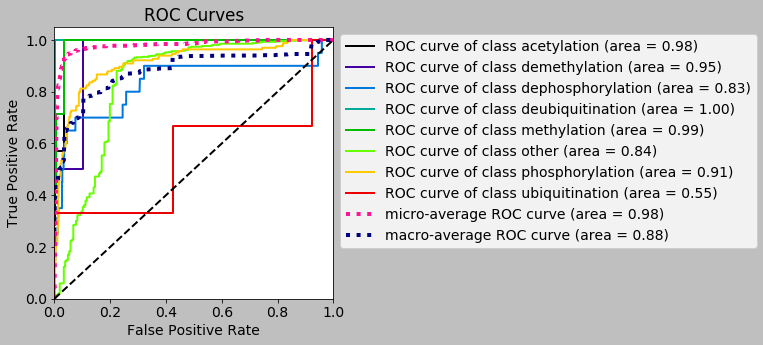

In [66]:
plot_roc_curve(df_single_test_results)

In [67]:
df_ensemble.head(n=2)

,actual,normalised_abstract,participant1Id,participant2Id,index,votes_acetylation,votes_demethylation,votes_dephosphorylation,votes_deubiquitination,votes_methylation,votes_other,votes_phosphorylation,votes_ubiquitination,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination,ensemble_predicted_confidence,ensemble_predicted,ensemble_majority_prediction,ensemble_confidence_majority_prediction,particpant1Exists,particpant2Exists,particpantsExists
0,other,"Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of Q99759 is an autophosphorylation site within the T-loop that is regulated by Q15257 and 14-3-3 proteins.",Q15257,P52564,0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,3.113588,1.421410,13.044765,2.022279,2.234575,2691.359356,12.067992,2.587008,0.986623,other,other,2691.359356,True,True,True
1,other,"Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatas

In [68]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

def probability_threshold(df, confidence_field, predicted_field):
    result = []
    l, u = min(df[confidence_field]), max(df[confidence_field])
    threshold = 0
    step = round( (u-0)/50, 2)
    majority_class = df.groupby(["actual"]).size().idxmax()
    max_valuecounts =  df.groupby(["actual"]).size().max()
    while threshold <= u :
        df_filter = df.query("{} >=  {}".format(confidence_field, threshold))
        max_valuecounts_filter = df_filter.query("actual == '{}'".format(majority_class)).shape[0]


        result.append ({
            "baseline_accuracy" : max_valuecounts/df.shape[0],
            "baseline_accuracy_threshold" : max_valuecounts_filter/df_filter.shape[0],
            "threshold" : threshold,
            "records" : df_filter.shape[0],
            "percentage_records_retained" : df_filter.shape[0]/df.shape[0],
            "normalised_threshold" : (threshold -0 )/(u-0),
            "F1_macro": f1_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None)  ,
            "precision_macro":precision_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "recall_macro": recall_score(df_filter["actual"], df_filter[predicted_field], average='macro' ,sample_weight=None) , 
            "F1_micro":    f1_score(df_filter["actual"], df_filter[predicted_field], average='micro' ,sample_weight=None) ,
            "accuracy":accuracy_score(df_filter["actual"], df_filter[predicted_field],sample_weight=None)
        })
        threshold += step
        
    return pd.DataFrame(result)



In [69]:
pt_ensemble_majority_prediction = probability_threshold(df_ensemble,"ensemble_confidence_majority_prediction", "ensemble_majority_prediction")
pt_ensemble_prediction = probability_threshold(df_ensemble,"ensemble_predicted_confidence", "ensemble_predicted")
pt_best_prediction = probability_threshold(best_df,"predicted_confidence", "predicted")

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


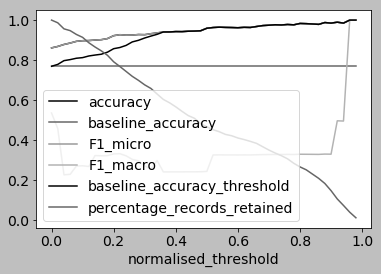

In [70]:
pt_ensemble_majority_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" ,"F1_micro", "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold")

In [71]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=False).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
49,1.000000,1.000000,1.000000,0.769575,1.000000,0.980017,0.013423,1.000000,1.000000,12,12607.21
48,1.000000,1.000000,1.000000,0.769575,1.000000,0.960016,0.041387,1.000000,1.000000,37,12349.92
47,0.496241,0.985075,0.985075,0.769575,0.985075,0.940016,0.074944,0.492537,0.500000,67,12092.63
46,0.497382,0.989583,0.989583,0.769575,0.989583,0.920016,0.107383,0.494792,0.500000,96,11835.34
45,0.330808,0.984962,0.984962,0.769575,0.984962,0.900015,0.148770,0.328321,0.333333,133,11578.05
44,0.331301,0.987879,0.987879,0.769575,0.987879,0.880015,0.184564,0.329293,0.333333,165,11320.76
43,0.329749,0.978723,0.978723,0.769575,0.978723,0.860015,0.210291,0.326241,0.333333,188,11063.47
42,0.330081,0.980676,0.980676,0.769575,0.980676,0.840014,0.231544,0.326892,0.333333,207,10806.18
41,0.330357,0.982301,0.982301,0.769575,0.982301,0.820014,0.252796,0.327434,0.333333,226,10548.89
40,0.330520,0.983264,0.983264,0.769575,0.983264,0.800014,0.267338,0.327755,0.333333,239,10291.60


In [72]:
df_ensemble.query("ensemble_confidence_majority_prediction > 12095")["actual"].value_counts()

other                66
dephosphorylation     1
Name: actual, dtype: int64

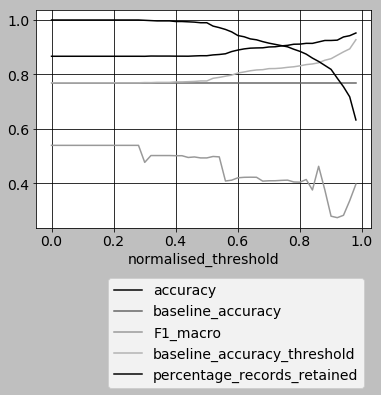

In [73]:
pt_ensemble_prediction   [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_ensmebl.png", bbox_inches='tight')

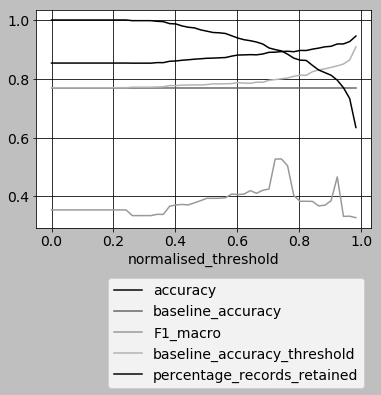

In [74]:
pt_best_prediction  [["normalised_threshold","accuracy", "baseline_accuracy" , "F1_macro","baseline_accuracy_threshold", "percentage_records_retained" ]].plot(x="normalised_threshold", grid=True).legend(bbox_to_anchor=(1, -0.2))
plt.savefig("pb_threhold_best.png", bbox_inches='tight')

In [75]:
pt_ensemble_prediction.sort_values(by=["threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.53996,0.86689,0.86689,0.769575,0.769575,0.000000,1.0,0.663674,0.51398,894,0.00
1,0.53996,0.86689,0.86689,0.769575,0.769575,0.020034,1.0,0.663674,0.51398,894,0.02
2,0.53996,0.86689,0.86689,0.769575,0.769575,0.040067,1.0,0.663674,0.51398,894,0.04
3,0.53996,0.86689,0.86689,0.769575,0.769575,0.060101,1.0,0.663674,0.51398,894,0.06
4,0.53996,0.86689,0.86689,0.769575,0.769575,0.080135,1.0,0.663674,0.51398,894,0.08
5,0.53996,0.86689,0.86689,0.769575,0.769575,0.100168,1.0,0.663674,0.51398,894,0.10
6,0.53996,0.86689,0.86689,0.769575,0.769575,0.120202,1.0,0.663674,0.51398,894,0.12
7,0.53996,0.86689,0.86689,0.769575,0.769575,0.140235,1.0,0.663674,0.51398,894,0.14
8,0.53996,0.86689,0.86689,0.769575,0.769575,0.160269,1.0,0.663674,0.51398,894,0.16
9,0.53996,0.86689,0.86689,0.769575,0.769575,0.180303,1.0,0.663674,0.51398,894,0.18


In [76]:
pt_best_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.35378,0.853468,0.853468,0.769575,0.769575,0.000000,1.0,0.343608,0.383286,894,0.00
1,0.35378,0.853468,0.853468,0.769575,0.769575,0.020061,1.0,0.343608,0.383286,894,0.02
2,0.35378,0.853468,0.853468,0.769575,0.769575,0.040122,1.0,0.343608,0.383286,894,0.04
3,0.35378,0.853468,0.853468,0.769575,0.769575,0.060182,1.0,0.343608,0.383286,894,0.06
4,0.35378,0.853468,0.853468,0.769575,0.769575,0.080243,1.0,0.343608,0.383286,894,0.08
5,0.35378,0.853468,0.853468,0.769575,0.769575,0.100304,1.0,0.343608,0.383286,894,0.10
6,0.35378,0.853468,0.853468,0.769575,0.769575,0.120365,1.0,0.343608,0.383286,894,0.12
7,0.35378,0.853468,0.853468,0.769575,0.769575,0.140426,1.0,0.343608,0.383286,894,0.14
8,0.35378,0.853468,0.853468,0.769575,0.769575,0.160487,1.0,0.343608,0.383286,894,0.16
9,0.35378,0.853468,0.853468,0.769575,0.769575,0.180547,1.0,0.343608,0.383286,894,0.18


In [77]:
k

's3://aegovan-data/results/ppi-bert-2019-11-24-17-22-16-517/output/output.tar.gz'

In [78]:
pt_ensemble_majority_prediction.sort_values(by=["normalised_threshold"], ascending=True).head(n=10)

,F1_macro,F1_micro,accuracy,baseline_accuracy,baseline_accuracy_threshold,normalised_threshold,percentage_records_retained,precision_macro,recall_macro,records,threshold
0,0.536480,0.861298,0.861298,0.769575,0.769575,0.000000,1.000000,0.626365,0.515684,894,0.00
1,0.459030,0.868481,0.868481,0.769575,0.778912,0.020000,0.986577,0.552980,0.411195,882,257.29
2,0.227856,0.878363,0.878363,0.769575,0.797661,0.040001,0.956376,0.246206,0.218662,855,514.58
3,0.230419,0.885478,0.885478,0.769575,0.802834,0.060001,0.947427,0.248408,0.220997,847,771.87
4,0.271581,0.893976,0.893976,0.769575,0.809639,0.080001,0.928412,0.294847,0.259262,830,1029.16
5,0.273043,0.897185,0.897185,0.769575,0.812729,0.100002,0.913870,0.296428,0.260524,817,1286.45
6,0.269536,0.897856,0.897856,0.769575,0.820933,0.120002,0.887025,0.299025,0.255170,793,1543.74
7,0.323883,0.900517,0.900517,0.769575,0.825581,0.140002,0.865772,0.358664,0.306587,774,1801.03
8,0.322808,0.902246,0.902246,0.769575,0.829590,0.160003,0.846756,0.360233,0.304667,757,2058.32
9,0.323622,0.907734,0.907734,0.769575,0.839891,0.180003,0.824385,0.362275,0.304728,737,2315.61
